# Анализ A/B-теста для интернет-магазина

## 1. Вводные

### 1.1. Задача
Мы запустили A/B-тест и получили результаты в файлах orders.csv и visitors.csv. Нужно проанализировать результаты. В первую очередь интересует влияние на выручку. Декомпозировать её можно на изменение конверсии из посетителя в покупателя и среднего чека покупки.

### 1.2. Описание данных
orders.csv
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

visitors.csv
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## 2. Обзор и предобработка данных

### 2.1. Подготовка к анализу и загрузка данных 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'  # переключаем на векторную графику

import warnings
warnings.simplefilter('ignore')  # отключаем предупредения Anaconda

from functools import partialmethod
pd.DataFrame.query = partialmethod(pd.DataFrame.query, engine='python')  # просим query() всегда работать
                                                                         # с параметром engine='python'

In [2]:
# Локальные адреса файлов
try:
    orders = pd.read_csv('orders.csv')
    users = pd.read_csv('visitors.csv')

# Адреса в тренажёре
except:  
    orders = pd.read_csv('/datasets/orders.csv')
    users = pd.read_csv('/datasets/visitors.csv')

### 2.2. Заказы

In [3]:
# Познакомимся с данными
orders.info()
orders.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,date,revenue,group
1137,2183069967,759473111,2019-08-13,52480,A


In [4]:
# Приведём названия столбцов к snake_case и назовём более лаконично
orders.columns = ['order_id', 'user_id', 'date', 'revenue', 'group']

In [5]:
# Преобразуем тип даты в datetime.date
orders['date'] = pd.to_datetime(orders['date']).dt.date

In [6]:
# Проверим наличие дубликатов в категориальных переменных
orders['group'].value_counts()

B    640
A    557
Name: group, dtype: int64

In [7]:
# Проверим, что все transaction_id уникальны
orders['order_id'].duplicated().sum()

0

In [8]:
# Проверим наличие явных дубликатов в строках
orders.duplicated().sum()

0

In [9]:
# Валидация выручки на положительность
orders[orders['revenue'] <= 0]

,order_id,user_id,date,revenue,group


(datetime.date(2019, 8, 1), datetime.date(2019, 8, 31), 31)

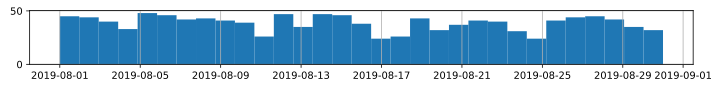

In [10]:
# Посмотрим на распределение заказов по дням
orders['date'].hist(bins=(max(orders['date']) - min(orders['date'])).days + 1, figsize=(12, 1))
min(orders['date']), max(orders['date']), (max(orders['date']) - min(orders['date'])).days + 1

<AxesSubplot:>

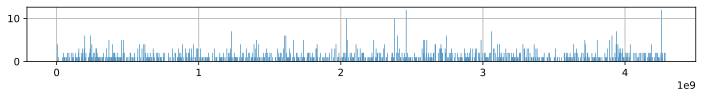

In [11]:
# Посмотрим на распределение заказов по пользователям
orders['user_id'].hist(bins=orders['user_id'].nunique(), figsize=(12, 1))

<AxesSubplot:>

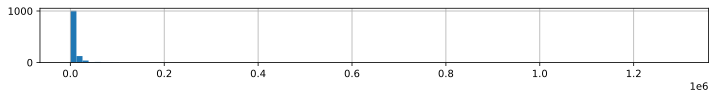

In [12]:
# Оценим распределение выручки
orders['revenue'].hist(bins=100, figsize=(12, 1))

In [13]:
orders.head()

,order_id,user_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Пропусков, дубликатов и явных ошибок в данных — нет.

Срок проведения аб-теста: 31 день, c 1 по 31 августа. Заказы распределены по дням достаточно равномерно.

Пользователи в основном делали 1-2 заказа, но есть и те, кто сделал больше 10.

У нас много небольших по сумме заказов, чем крупнее сумма, тем таких меньше, но есть явные выбросы.

### 2.3. Визиты

In [14]:
# Познакомимся с данными
users.info()
users.sample()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,date,group,visitors
2,2019-08-03,A,507


In [15]:
# Приведём названия столбцов к snake_case и назовём более лаконично
users.columns = ['date', 'group', 'users']

In [16]:
# Преобразуем тип даты в datetime.date
users['date'] = pd.to_datetime(users['date']).dt.date

In [17]:
# Проверим наличие дубликатов в категориальных переменных
users['group'].value_counts()

A    31
B    31
Name: group, dtype: int64

In [18]:
# Проверим наличие явных дубликатов в строках
users.duplicated().sum()

0

In [19]:
# Валидация числа пользователей на положительность
users[users['users'] <= 0]

,date,group,users


(datetime.date(2019, 8, 1), datetime.date(2019, 8, 31), 31)

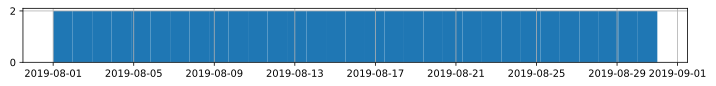

In [20]:
# Посмотрим на распределение дат
users['date'].hist(bins=(max(users['date']) - min(users['date'])).days + 1, figsize=(12, 1))
min(users['date']), max(users['date']), (max(users['date']) - min(users['date'])).days + 1

array([<AxesSubplot:title={'center':'A'}>,
       <AxesSubplot:title={'center':'B'}>], dtype=object)

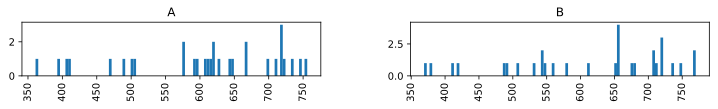

In [21]:
# Посмотрим на распределение числа пользователей в день
users[['users', 'group']].hist(bins=100, figsize=(12, 1), by='group')

In [22]:
users.head()

,date,group,users
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Пропусков, дубликатов и явных ошибок в данных — нет.

Есть данные за каждый из 31 дня по обеим группам теста.

В каждую группу теста попадало от 350 до 800 пользователей в день.

Явных аномалий в данных не найдено.

## 3. Подготовка и очистка данных

### 3.1. Количество заказов на пользователя

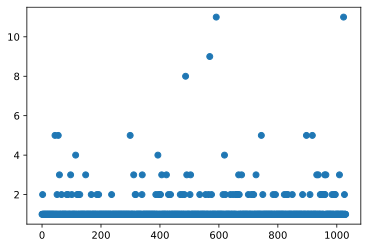

In [23]:
# Построим точечный график количества заказов по пользователям
orders_by_users = orders.groupby(by='user_id', as_index=False).agg({
    'order_id': 'nunique'
})
orders_by_users.columns = ['user_id', 'orders_count']

x_values = pd.Series(range(0, len(orders_by_users['orders_count'])))
plt.scatter(x_values, orders_by_users['orders_count'])
plt.show()

В основном пользователи делают 1-2 заказа за рассматриваемый месяц, но некоторые — значительно больше.

In [24]:
# Посчитаем 95-й и 99-й перцентили количества заказов на пользователя
print(*np.percentile(orders_by_users['orders_count'], [95, 99]))

2.0 4.0


Будем считать, что типичные пользователи делают 1-2 заказа, остальное поведение — аномальное.

In [25]:
# Запомним айдишники типичных пользователей
typical_users = orders_by_users.query("orders_count <= 2")['user_id']
len(typical_users), typical_users.head()

(1001,
 0     5114589
 1     6958315
 2     8300375
 3    11685486
 4    39475350
 Name: user_id, dtype: int64)

### 3.2. Стоимость заказов

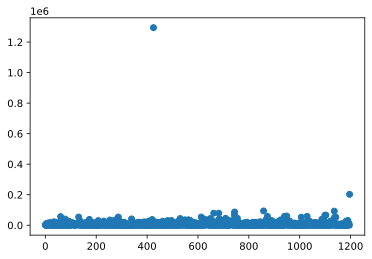

In [26]:
# Построим точечный график стоимостей заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.show()

In [27]:
# Посчитаем 1-й, 5-й, 95-й и 99-й перцентили стоимости заказов
print(*np.percentile(orders['revenue'], [1, 5, 95, 99]).round())

100.0 300.0 28000.0 58233.0


In [28]:
orders['revenue'].min()

50

Будем считать типичными заказы стоимостью от 100 до 30000. Остальные — аномальными.

In [29]:
# Запомним айдишники типичных (не аномальных) заказов
typical_orders = orders.query("100 < revenue <= 30000")['order_id']
len(typical_orders), typical_orders.head()

(1125,
 0    3667963787
 1    2804400009
 2    2961555356
 3    3797467345
 4    2282983706
 Name: order_id, dtype: int64)

### 3.3. Подготовка кумулятивных данных

In [30]:
def get_cum_data(orders, visits):

    """Функция для построения кумулятивных датафреймов по покупкам и визитам"""
    
    # Создадим датафрейм со всевозможными парами: дата и группа теста
    dates_groups = orders[['date', 'group']].drop_duplicates().sort_values(['date', 'group'])

    # Соберём агрегированные кумулятивные по дням данные о заказах
    orders_аggregated = dates_groups.apply(
        lambda x: orders[np.logical_and(orders['date'] <= x['date'],
                                        orders['group'] == x['group'])]
        .agg({
            'date': 'max',
            'group': 'max',
            'order_id': 'nunique',
            'user_id': 'nunique',
            'revenue': 'sum'
        }),
        axis=1
    )

    # Получим агрегированные кумулятивные по дням данные о посетителях 
    users_аggregated = dates_groups.apply(
        lambda x: users[np.logical_and(users['date'] <= x['date'],
                                       users['group'] == x['group'])]
        .agg({
            'date' : 'max',
            'group' : 'max',
            'users' : 'sum'
        }),
        axis=1
    )

    # Объединим кумулятивные данные в одной таблице и присваивоим столбцам понятные названия
    cumulative_data = orders_аggregated.merge(users_аggregated, on=['date', 'group'])
    cumulative_data.columns = ['date',
                               'group',
                               'orders',
                               'buyers',
                               'revenue',
                               'visitors',
                              ]

    # Рассчитаем кумулятивные средний чек и конверсию
    cumulative_data['avg_check'] = (cumulative_data['revenue'] / cumulative_data['buyers'])
    cumulative_data['conversion'] = (cumulative_data['buyers'] / cumulative_data['visitors'])

    # Сделаем отдельный датафрейм с кумулятивными данными по дням в группе А
    cumulative_data_a = cumulative_data[cumulative_data['group']=='A'][['date',
                                                                        'revenue',
                                                                        'orders',
                                                                        'avg_check',
                                                                        'conversion',
                                                                        # Сбросим индекс, чтобы можно было делить
                                                                        # столбцы одного датафрейма на столбцы другого
                                                                       ]].reset_index(drop=True)

    # И аналогичный датафрейм для группы B
    cumulative_data_b = cumulative_data[cumulative_data['group']=='B'][['date',
                                                                        'revenue',
                                                                        'orders',
                                                                        'avg_check',
                                                                        'conversion',
                                                                       ]].reset_index(drop=True)    

    return cumulative_data, cumulative_data_a, cumulative_data_b

In [31]:
cumulative_data, cumulative_data_a, cumulative_data_b = get_cum_data(orders, users)

display(cumulative_data.head(), cumulative_data_a.head(), cumulative_data_b.head())

,date,group,orders,buyers,revenue,visitors,avg_check,conversion
0,2019-08-01,A,24,20,148579,719,7428.950000,0.027816
1,2019-08-01,B,21,20,101217,713,5060.850000,0.028050
2,2019-08-02,A,44,38,242401,1338,6378.973684,0.028401
3,2019-08-02,B,45,43,266748,1294,6203.441860,0.033230
4,2019-08-03,A,68,62,354874,1845,5723.774194,0.033604


,date,revenue,orders,avg_check,conversion
0,2019-08-01,148579,24,7428.950000,0.027816
1,2019-08-02,242401,44,6378.973684,0.028401
2,2019-08-03,354874,68,5723.774194,0.033604
3,2019-08-04,425699,84,5528.558442,0.030055
4,2019-08-05,549917,109,5499.170000,0.030139


,date,revenue,orders,avg_check,conversion
0,2019-08-01,101217,21,5060.850000,0.028050
1,2019-08-02,266748,45,6203.441860,0.033230
2,2019-08-03,380996,61,6457.559322,0.032723
3,2019-08-04,489567,78,6527.560000,0.029149
4,2019-08-05,581995,101,5938.724490,0.029878


### 3.4. Очистка кумулятивных данных
#### 3.4.1. Очистка заказов

In [32]:
# Очистим заказы от выбросов
filtered_orders = orders.query("order_id in @typical_orders and user_id in @typical_users")

#### 3.4.2. Очистка визитов

In [33]:
# Найдём количество аномальных заказов каждого пользователя (за каждый день в каждой группе)
abnormal_revenue_users = pd.DataFrame(orders.query("order_id not in @typical_orders")
                                      .groupby(['date', 'group', 'user_id'])['order_id']
                                      .count()
                                     ).reset_index()
abnormal_revenue_users.columns = ['date', 'group', 'user_id', 'abnormal_orders_count']

# Посчитаем, сколько всего заказов делали такие пользователи (за каждый день в каждой группе)
orders_by_abnormal_revenue_users = pd.DataFrame(
    orders.query("user_id in @abnormal_revenue_users['user_id']")
          .groupby(['date', 'group', 'user_id'])['order_id']
          .count()
).reset_index()
orders_by_abnormal_revenue_users.columns = ['date', 'group', 'user_id', 'orders_count']

# Объединим данные
abnormal_revenue_users = abnormal_revenue_users.merge(orders_by_abnormal_revenue_users,
                                                      on=['date', 'group', 'user_id'],
                                                      how='left')

# Запомним пользователей, у которых все заказы были на аномальную сумму (за каждый день в каждой группе)
abnormal_revenue_users = (
    abnormal_revenue_users.query("abnormal_orders_count == orders_count")
                          .drop(columns=['abnormal_orders_count', 'orders_count'])
)

print(abnormal_revenue_users.shape[0])
abnormal_revenue_users.head()

71


,date,group,user_id
0,2019-08-02,B,2830871062
1,2019-08-02,B,2953427180
2,2019-08-02,B,3118156181
3,2019-08-04,B,2247666522
4,2019-08-05,A,1831956319


In [34]:
# Найдём пользователей, которые сделали нетипично много заказов (за каждый день в каждой группе)
abnormal_orders_users = orders.query("user_id not in @typical_users")[['date', 'group', 'user_id']].drop_duplicates()

print(abnormal_orders_users.shape[0])
abnormal_orders_users.head()

115


,date,group,user_id
15,2019-08-15,B,2742574263
26,2019-08-15,A,199603092
27,2019-08-15,B,237748145
29,2019-08-15,A,3803269165
32,2019-08-15,B,2038680547


In [35]:
# Объединим датафреймы аномальных пользователей (за каждый день в каждой группе)
abnormal_users = pd.concat([abnormal_revenue_users, abnormal_orders_users]).drop_duplicates()

# Посчитаем, сколько сессий аномальных пользователей было каждый день
abnormal_users_count = abnormal_users.groupby(['date', 'group']).nunique()
abnormal_users_count.columns = ['users']

print(abnormal_users.shape[0], abnormal_users_count.shape[0])
abnormal_users_count.head(6)

179 59


users
date       group       
2019-08-01 A          3
           B          1
2019-08-02 A          1
           B          4
2019-08-03 B          2
2019-08-04 A          4

In [36]:
# Приведём данные о визитах к аналогичной структуре данных и посмотрим на первые строки
users.set_index(['date', 'group']).sort_values(['date', 'group']).head(6)

users
date       group       
2019-08-01 A        719
           B        713
2019-08-02 A        619
           B        581
2019-08-03 A        507
           B        509

In [37]:
# Создадим датафрейи для очищеных визитов, для начала просто скопируем в него визиты
filtered_users = pd.DataFrame(users.set_index(['date', 'group'])['users']).sort_values(['date', 'group'])

# Добавим столбец с количеством аномальных пользователей, заполнив нулями те группы и даты, где таких не нашлось
filtered_users['abnormal_users'] = abnormal_users_count['users']
filtered_users.fillna(0, inplace=True)

# Вычтем их визитов количество аномальных пользователей (не учитываем их в визитах)
filtered_users['users'] = (filtered_users['users'] - filtered_users['abnormal_users']).astype('int')

# Удалим ненужную колонку и сбросим индекс
filtered_users = filtered_users.drop(columns=['abnormal_users']).reset_index()

# Приведём дату к типу datetime.date
filtered_users['date'] = pd.to_datetime(filtered_users['date']).dt.date

# Теперь визиты очищены
filtered_users.head(6)

,date,group,users
0,2019-08-01,A,716
1,2019-08-01,B,712
2,2019-08-02,A,618
3,2019-08-02,B,577
4,2019-08-03,A,507
5,2019-08-03,B,507


#### 3.4.3. Построение очищенных кумулятивных данных

In [38]:
filtered_cumulative_data, filtered_cumulative_data_a, filtered_cumulative_data_b = get_cum_data(filtered_orders,
                                                                                                filtered_users)
display(filtered_cumulative_data.head(), filtered_cumulative_data_a.head(), filtered_cumulative_data_b.head())

,date,group,orders,buyers,revenue,visitors,avg_check,conversion
0,2019-08-01,A,18,17,112340,719,6608.235294,0.023644
1,2019-08-01,B,19,19,78258,713,4118.842105,0.026648
2,2019-08-02,A,37,35,204472,1338,5842.057143,0.026158
3,2019-08-02,B,39,38,171392,1294,4510.315789,0.029366
4,2019-08-03,A,61,59,316945,1845,5371.949153,0.031978


,date,revenue,orders,avg_check,conversion
0,2019-08-01,112340,18,6608.235294,0.023644
1,2019-08-02,204472,37,5842.057143,0.026158
2,2019-08-03,316945,61,5371.949153,0.031978
3,2019-08-04,358121,72,5116.014286,0.027322
4,2019-08-05,467754,95,5084.282609,0.027728


,date,revenue,orders,avg_check,conversion
0,2019-08-01,78258,19,4118.842105,0.026648
1,2019-08-02,171392,39,4510.315789,0.029366
2,2019-08-03,238441,53,4585.403846,0.028841
3,2019-08-04,312382,67,4805.876923,0.025262
4,2019-08-05,402215,87,4731.941176,0.025915


## 4. Анализ А/Б-теста

### 4.1. Подготовка функций для визуализации параметров

In [39]:
def plot_ab(cumulative_data_a,
            cumulative_data_b,
            filtered_cumulative_data_a,
            filtered_cumulative_data_b,
            dimension,
            title):
    
    """ Функция строит:
        - график кумулятивного параметра dimension по группам теста
        - график относительного изменения кумулятивного по дням параметра dimension группы B к A
        Оба графика строятся для «сырых» и «очищенных» данных
    """
    
    plt.figure(figsize=(10, 8))

    # Строим график кумулятивного среднего чека по группам
    ax = plt.subplot(2, 1, 1)

    # По сырым данным
    plt.plot(cumulative_data_a['date'], cumulative_data_a[dimension],
             label='A, Raw data', linestyle=':', color='blue')
    plt.plot(cumulative_data_b['date'], cumulative_data_b[dimension],
             label='B, Raw data', linestyle=':', color='red')

    # По очищенным данным
    plt.plot(filtered_cumulative_data_a['date'], filtered_cumulative_data_a[dimension],
             label='A, Cleared data', color='blue')
    plt.plot(filtered_cumulative_data_b['date'], filtered_cumulative_data_b[dimension],
             label='B, Cleared data', color='red')

    plt.title(title + ' по группам')
    plt.grid()
    plt.legend()


    # Строим графики относительного изменения кумулятивного среднего чека группы B к группе A
    ax = plt.subplot(2, 1, 2)

    # По сырым данным
    plt.plot(cumulative_data_a['date'],
             cumulative_data_b[dimension] / cumulative_data_a[dimension] - 1,
             label='Raw data', linestyle=':', color='brown',
            )

    # По очищенным данным
    plt.plot(filtered_cumulative_data_a['date'],
             filtered_cumulative_data_b[dimension] / filtered_cumulative_data_a[dimension] - 1,
             label='Cleared data', color='green',
            )

    plt.axhline(y=0, color='#555555', linestyle='--') 
    plt.title(title + ': относительное изменение группы B к группе A')
    plt.grid()
    plt.legend()

    plt.tight_layout()
    plt.show()

### 4.2. Выручка

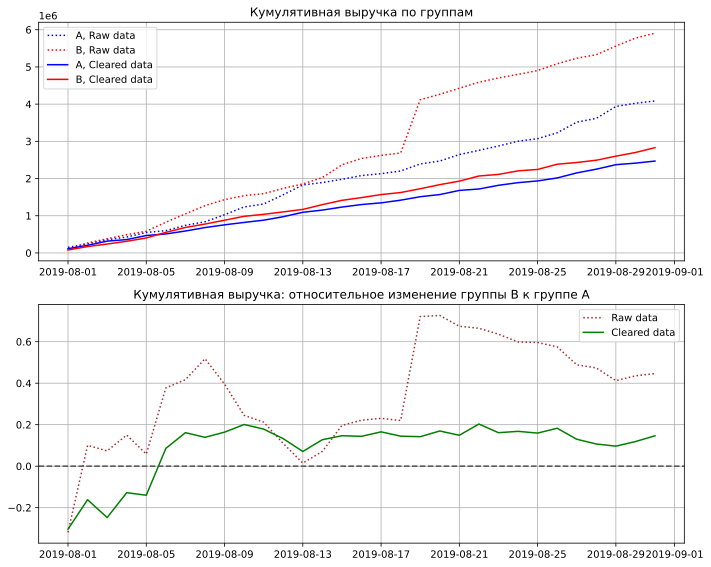

In [40]:
# Построим график кумулятивной выручки по группам
plot_ab(cumulative_data_a, cumulative_data_b, filtered_cumulative_data_a, filtered_cumulative_data_b,
        'revenue',
        'Кумулятивная выручка')

На первый взгляд по сырым данным уверенно побеждает вариант B, но смущает резкий скачок выручки 20 августа. Похоже какой-то пользователь сделал в этот день заказ на нетипично большую сумму.

Очищенные данные подтверждают эту гипотезу. Для типичных пользователей и заказов графики после первой недели теста стабилизировались. Вариант B показывает выручку примерно на 15% большую, чем вариант A.

### 4.3. Средний чек

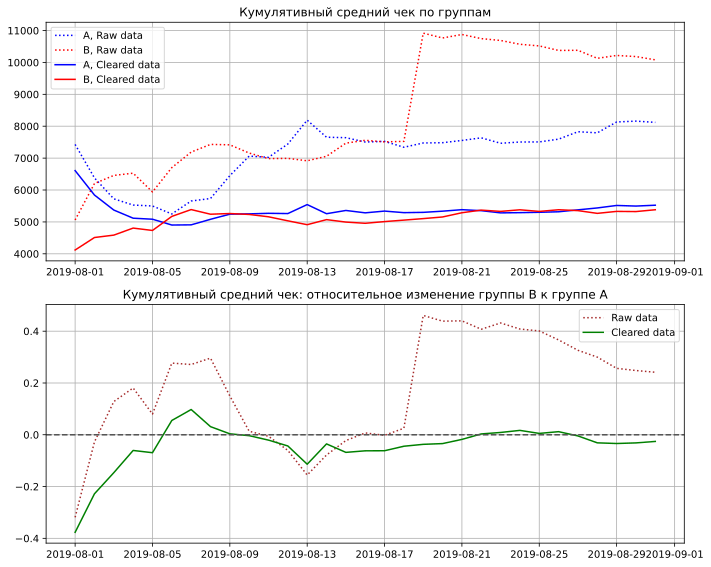

In [41]:
# Построим график кумулятивного среднего чека по группам
plot_ab(cumulative_data_a, cumulative_data_b, filtered_cumulative_data_a, filtered_cumulative_data_b,
        'avg_check',
        'Кумулятивный средний чек')

Здесь аналогичная картина. На первый средний чек в варианте B сильно выше, но есть резкий скачок кумулятивного среднего чека 20 августа, что указывает на то, что там были заказы на нетипично большие суммы. 

Очищенные же данные показывают более стабильную картину, по которой сложно уверенно сказать, что в какой-то из групп средний чек явно выше. Значительной разницы в средних чеках не видно. Относительный график колеблется около нуля. «На глаз» сложно сказать, есть ли значимая разница в среднем чеке между группами. Тут нам поможет статистический тест, которые проведём ниже.

### 4.4. Конверсия

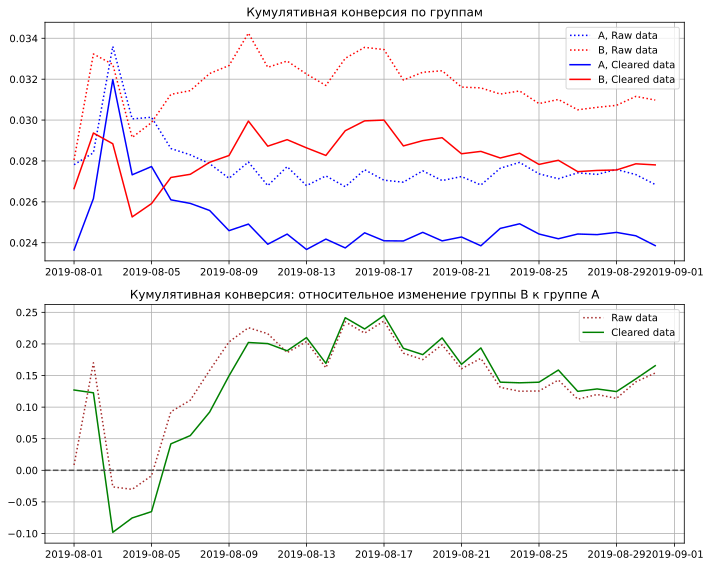

In [42]:
# Построим график кумулятивной конверсии по группам
plot_ab(cumulative_data_a, cumulative_data_b, filtered_cumulative_data_a, filtered_cumulative_data_b,
        'conversion',
        'Кумулятивная конверсия')

После первых полутора недель теста графики конверсии стабилизировались и вариант B явно выигрывает. Причём это видно как на сырых, так и на очищенных данных. Конверсия варианта B примерно на 15% выше, чем в группе A.

Теперь примерно понятна вся картина. Тестируемое изменение в варианте B улучшило конверсию в покупки и не сильно повлияло на средний чек, в результате выручка в варианте B выше. Осталось проверить эту гипотезу статистическими тестами. 

### 4.5. Анализ статистической значимости

#### 4.5.1. Подготовка данных и функций

In [43]:
def get_per_date_data(orders, visitors):
    
    """ Функция строит датафрейм с данными о выручке, числе покупателей, заказов и посетителей.
        А также конверсии и среднем чеке по дням и группам теста.
        Возвращает общий датафрейм и два семпла с данными, разделёнными по группам теста. 
    """
    per_date_data = orders.groupby(['date', 'group']).agg({
        'revenue': 'sum',
        'user_id': 'nunique',
        'order_id': 'nunique'
    }).reset_index().merge(visitors, on=['date', 'group'])
    per_date_data.columns = ['date', 'group', 'revenue', 'buyers', 'orders', 'visitors']

    per_date_data['avg_check'] = per_date_data['revenue'] / per_date_data['orders']
    per_date_data['conversion'] = per_date_data['buyers'] / per_date_data['visitors']

    sample_a = per_date_data.query("group == 'A'").drop(columns=['group'])
    sample_b = per_date_data.query("group == 'B'").drop(columns=['group'])
    
    return per_date_data, sample_a, sample_b

In [44]:
def mw_test(sample_a, sample_b, dimention):
    
    """ Функция проводит тест Манна-Уитни на двух наборах данных по указанному столбцу
        А также рассчитывает относительный прирост этого столбца в группе B
    """
    
    print('pvalue = {0:.3f}'.format(st.mannwhitneyu(sample_a[dimention],
                                                    sample_b[dimention])[1]))

    print('Относительный прирост ' + dimention +  ' группы B = {0:.3f}'.format(
        sample_b[dimention].mean()
        / sample_a[dimention].mean()
        - 1)
    )

In [45]:
# Получаем подневные данные
per_date_data, sample_a, sample_b = get_per_date_data(orders, users)
filtered_per_date_data, filtered_sample_a, filtered_sample_b = get_per_date_data(filtered_orders, filtered_users)

In [46]:
# Проверяем, как выглядят сэмплы данных по группам теста
display(sample_a.sample(),
        sample_b.sample(),
        filtered_sample_a.sample(),
        filtered_sample_b.sample(),
       )

,date,revenue,buyers,orders,visitors,avg_check,conversion
54,2019-08-28,101122,17,17,594,5948.352941,0.02862


,date,revenue,buyers,orders,visitors,avg_check,conversion
11,2019-08-06,242342,26,28,655,8655.071429,0.039695


,date,revenue,buyers,orders,visitors,avg_check,conversion
26,2019-08-14,59251,22,22,733,2693.227273,0.030014


,date,revenue,buyers,orders,visitors,avg_check,conversion
57,2019-08-29,109050,16,16,527,6815.625,0.030361


#### 4.5.2. Конверсия
Сформулируем гипотезы.

Нулевая: 
> **различий в средней конверсии между группами нет**.

Альтернативная: 

> **различия — есть**.

Уровень статистической значимости выберем равным 5%.

Будем использовать непараметрический тест.

In [47]:
# Тест Манна-Уитни на сырых данных
mw_test(sample_a, sample_b, 'conversion')

pvalue = 0.074
Относительный прирост conversion группы B = 0.158


In [48]:
# Тест Манна-Уитни на очищенных данных
mw_test(filtered_sample_a, filtered_sample_b, 'conversion')

pvalue = 0.030
Относительный прирост conversion группы B = 0.189


На сырых данных p-value получилось больше уровня статистической значимости, если бы мы остановились на этом, не смогли бы отвергнуть нулевую гипотезу. 

Но рассматривая поведение типичных пользователей и типичные заказы, p-value получилось равным 3%, что ниже выбранного уровня значимости. А значит отвергаем нулевую гипотезу и принимаем альтернативную: между группами есть статистически-значимая разница в конверсии, относительный прирост конверсиии группы B ≈ 19%. 

#### 4.5.2. Средний чек

Сформулируем гипотезы.

Нулевая: 
> **различий в среднем чеке между группами нет**.

Альтернативная: 

> **различия — есть**.

Уровень статистической значимости выберем равным 5%.

In [49]:
# Тест Манна-Уитни на сырых данных
mw_test(sample_a, sample_b, 'avg_check')

pvalue = 0.406
Относительный прирост avg_check группы B = 0.244


In [50]:
# Тест Манна-Уитни на очищенных данных
mw_test(filtered_sample_a, filtered_sample_b, 'avg_check')

pvalue = 0.456
Относительный прирост avg_check группы B = -0.044


p-value в тестах как по сырым, так и по очищенным значительно выше выбранного уровня значимости, а значит у нас нет оснований отвергать нулевую гипотезу.

## 5. Выводы

Визуальный анализ показывает, что графики по кумулятивным выручке, конверсии и среднему чеку стабилизировались.

Не наблюдается статистически-значимой разницы среднего чека между группами. 

С конверсией же наоборот: группа B показывает статистически значимый прирост относительно группы A на 19%.

Рекомендую остановить тест, зафиксировать победу группы B.